In [1]:
#Prepare and process data
import math
import pandas as pd #read data file csv
import matplotlib.pyplot as plt #draw chart
import matplotlib.ticker as ticker #Format
import numpy as np #data processing
from keras.callbacks import ModelCheckpoint #keep good training
from tensorflow.keras.models import load_model #download model
from sklearn.preprocessing import MinMaxScaler #normalize data 0->1
#Training, model building
from keras.models import Sequential #input
from keras.layers import Dropout #avoid overfitting
from keras.layers import LSTM #dependent learning
from keras.layers import Dense #output
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers

#Phân tích chỉ số
from sklearn.metrics import r2_score #measure suitability
from sklearn.metrics import mean_squared_error #measure MSE and RMSE = sqrt(MSE)
from sklearn. metrics import mean_absolute_error #measure mean absolute error
from sklearn.metrics import mean_absolute_percentage_error #measure the mean percent absolute error

In [2]:
#Kết nội google colab với drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv('/content/drive/MyDrive/Coffee Forcasting/data.csv')
df

,Date,price_coffee,price_oil
0,2008-01-14,2051.0,94.20
1,2008-01-15,2036.0,91.90
2,2008-01-16,2040.0,90.84
3,2008-01-17,2037.0,90.13
4,2008-01-18,2027.0,90.57
...,...,...,...
3861,2023-06-30,2697.0,70.64
3862,2023-07-03,2750.0,69.79
3863,2023-07-04,2744.0,71.06
3864,2023-07-05,2713.0,71.79


In [4]:
df.info() # kiểm tra dữ liệu đã được định dạng

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3866 entries, 0 to 3865
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          3866 non-null   object 
 1   price_coffee  3866 non-null   float64
 2   price_oil     3866 non-null   float64
dtypes: float64(2), object(1)
memory usage: 90.7+ KB


In [5]:
correlation = df['price_coffee'].corr(df['price_oil'])

print(" Correlation coefficient: ", correlation)

 Correlation coefficient:  0.5495405027686284


In [6]:
#Định dạng lại cấu trúc của cột Date (định dạng năm-tháng-ngày)
df["Date"]=pd.to_datetime(df.Date,format="%Y/%m/%d")

In [7]:
df=pd.DataFrame(df,columns=['Date','price_coffee','price_oil'])
df.index=df.Date
df.drop("Date",axis=1, inplace=True)

In [8]:
df

,price_coffee,price_oil
Date,,
2008-01-14,2051.0,94.20
2008-01-15,2036.0,91.90
2008-01-16,2040.0,90.84
2008-01-17,2037.0,90.13
2008-01-18,2027.0,90.57
...,...,...
2023-06-30,2697.0,70.64
2023-07-03,2750.0,69.79
2023-07-04,2744.0,71.06


<Axes: xlabel='Date'>

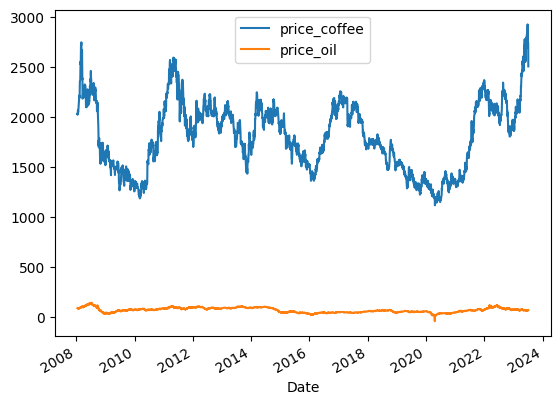

In [9]:
df_for_plot=df.tail(3865)
df_for_plot.plot.line()# df_for_plot=df_for_training.tail(5000)

## **Devided Data**

In [10]:
df.shape #kiểm tra số dòng của dữ liệu

(3866, 2)

In [11]:
df.values

array([[2051.  ,   94.2 ],
       [2036.  ,   91.9 ],
       [2040.  ,   90.84],
       ...,
       [2744.  ,   71.06],
       [2713.  ,   71.79],
       [2510.  ,   71.8 ]])

In [12]:
data=df.values
training_data_len = math.ceil(len(data)* 0.8)
train_data = data[0: training_data_len, :]
train_data.shape
test_data=data[training_data_len:]
test_data.shape

(773, 2)

In [13]:
train_data

array([[2051.  ,   94.2 ],
       [2036.  ,   91.9 ],
       [2040.  ,   90.84],
       ...,
       [1198.  ,   36.81],
       [1218.  ,   37.29],
       [1210.  ,   37.41]])

In [14]:
#Tiến hành chuẩn hoá lại dữ liệu với các giá trị được đưa về từ 0-1
sc=MinMaxScaler(feature_range=(0,1))
#Chuẩn hoá dữ liệu có tên data
sc_train=sc.fit_transform(data)

In [15]:
sc

MinMaxScaler()

In [16]:
sc_train

array([[0.51409619, 0.72069757],
       [0.50580431, 0.70812377],
       [0.50801548, 0.70232889],
       ...,
       [0.89718076, 0.59419418],
       [0.88004422, 0.598185  ],
       [0.76782753, 0.59823967]])

In [17]:

trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.


In [18]:
train_data.shape[1]

2

In [19]:
# 8-2
#Tiến hành kahi báo 2 mảng dử liệu x_train và y_train
# x_train,y_train=[],[]
# for i in range(15,len(train_data)): #tạo vòng lặp
#   x_train.append(sc_train[i-15:i,0]) #.append gán phần tử vào cuối mảng, bởi vì số ngày sẽ học để dự đoán 1 ngày tiếp theo là 60 nên -60 (mỗi mảng gồm giá 60 ngày)
#   y_train.append(sc_train[i,0])

for i in range(n_past, len(train_data) - n_future +1):
    trainX.append(sc_train[i - n_past:i, 0:train_data.shape[1]])
    trainY.append(sc_train[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (3079, 14, 2).
trainY shape == (3079, 1).


In [20]:
trainX

array([[[0.51409619, 0.72069757],
        [0.50580431, 0.70812377],
        [0.50801548, 0.70232889],
        ...,
        [0.54836926, 0.71047452],
        [0.54560531, 0.70730374],
        [0.55776672, 0.69205117]],

       [[0.50580431, 0.70812377],
        [0.50801548, 0.70232889],
        [0.5063571 , 0.69844741],
        ...,
        [0.54560531, 0.70730374],
        [0.55776672, 0.69205117],
        [0.57711443, 0.69784605]],

       [[0.50801548, 0.70232889],
        [0.5063571 , 0.69844741],
        [0.50082919, 0.70085283],
        ...,
        [0.55776672, 0.69205117],
        [0.57711443, 0.69784605],
        [0.57766722, 0.68904439]],

       ...,

       [[0.0326147 , 0.34665428],
        [0.01437258, 0.34397551],
        [0.02598121, 0.35638531],
        ...,
        [0.04311774, 0.39000656],
        [0.03758983, 0.39973759],
        [0.03150912, 0.39946425]],

       [[0.01437258, 0.34397551],
        [0.02598121, 0.35638531],
        [0.03150912, 0.36660835],
        .

In [21]:
trainX.shape[2]

2

In [22]:
# # 8-2
# #Xây dựng mô hình
# model=Sequential() #đầu vào, tạo list lưu trữ các danh sách (list)
# model.add(LSTM(units=64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)) # tạo lớp LSTM - mô tả thông tin đầu vào
# model.add(Dropout(0.5))
# model.add(LSTM(units=64, activation='relu', return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(units=32, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(25))
# model.add(Dropout(0.5)) #Tránh việc học thuộc (dùng để giả định một phần các unit bị ẩn đi trong quá trình training, qua đó làm giảm tích hòa trộn)
# model.add(Dense(trainY.shape[1])) #Đầu ra một chiều dùng để dự báo cho một giá trị (chiều đầu ra)
# model.compile(loss='mean_absolute_error', optimizer='adam') #mean_absolute_error: dụng để đánh giá sự sai khác giữa mô hình dự đoán và tập dữ liệu testing, adam: dùng để tối ưu tốc độ học
# model.summary()

from keras import regularizers

model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=32, activation='relu', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17152     
                                                                 
 dropout (Dropout)           (None, 14, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 14, 32)            12416     
                                                                 
 dropout_1 (Dropout)         (None, 14, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 25)                4

In [23]:

#huấn luyện mô hình mô hình
save_model="save_model.h5" #lưu lại mô hình với dạng file .h5
best_model=ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True, mode='auto') #tìm ra mô hình tốt nhất, save_best_only: lưu mô hình tốt nhất
model.fit(trainX, trainY, epochs=50,verbose=2,callbacks=best_model) #lưu dữ liệu phần epochs
# model.fit(x_train, y_train, batch_size= 32, epochs=30)




Epoch 1/50

Epoch 1: loss improved from inf to 0.29395, saving model to save_model.h5
97/97 - 21s - loss: 0.2940 - 21s/epoch - 213ms/step
Epoch 2/50

Epoch 2: loss improved from 0.29395 to 0.17463, saving model to save_model.h5
97/97 - 10s - loss: 0.1746 - 10s/epoch - 108ms/step
Epoch 3/50

Epoch 3: loss improved from 0.17463 to 0.13150, saving model to save_model.h5
97/97 - 10s - loss: 0.1315 - 10s/epoch - 108ms/step
Epoch 4/50

Epoch 4: loss improved from 0.13150 to 0.10718, saving model to save_model.h5
97/97 - 13s - loss: 0.1072 - 13s/epoch - 129ms/step
Epoch 5/50

Epoch 5: loss improved from 0.10718 to 0.09342, saving model to save_model.h5
97/97 - 8s - loss: 0.0934 - 8s/epoch - 83ms/step
Epoch 6/50

Epoch 6: loss improved from 0.09342 to 0.08389, saving model to save_model.h5
97/97 - 10s - loss: 0.0839 - 10s/epoch - 107ms/step
Epoch 7/50

Epoch 7: loss improved from 0.08389 to 0.07136, saving model to save_model.h5
97/97 - 11s - loss: 0.0714 - 11s/epoch - 109ms/step
Epoch 8/50

E

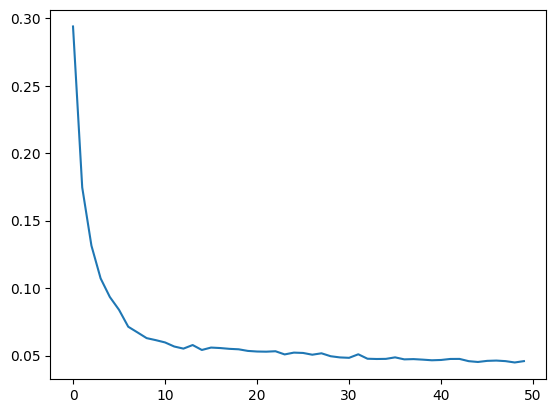

In [24]:
loss_per_epoch = model.history.history['loss']
plt.plot(loss_per_epoch)

In [25]:
loss = pd.DataFrame(loss_per_epoch, columns=['loss'])

In [26]:
loss.to_csv('loss_lstm.csv', index=False)

In [27]:
to.csv('')

NameError: ignored

In [ ]:
trainY

In [ ]:
train_data.shape

In [ ]:
# 8-2
prediction_copies = np.repeat(trainY, train_data.shape[1], axis=-1)
y_train=sc.inverse_transform(prediction_copies) #tiến hành xử lí số chuẩn hoá 0-1 thành giá vàng VND
final_model=load_model('save_model.h5') #load lại mô hình tốt nhất đã lưu
y_train_predict=final_model.predict(trainX) #giá dự đoán
y_train_predict = np.repeat(y_train_predict, train_data.shape[1], axis=-1)
y_train_predict=sc.inverse_transform(y_train_predict) #tiến hành xử lí số chuẩn hoá 0-1 thành giá vàng VND

In [ ]:
trainX

In [ ]:
trainXX = trainX[1:]

In [ ]:
trainXX

In [ ]:
# 8-2
test=df[len(train_data)-14:].values #trừ đi 14 ngày đầu tiên dùng để dự đoán ngày tiếp theo
test=test.reshape(-1,2)
sc_test=sc.transform(test)

x_test=[]
for i in range(n_past, len(test) - n_future +1):
    x_test.append(sc_test[i - n_past:i, 0:train_data.shape[1]])
x_test=np.array(x_test)

y_test=data[training_data_len:]
y_test_predict=final_model.predict(x_test)
y_test_predict = np.repeat(y_test_predict, train_data.shape[1], axis=-1)
y_test_predict=sc.inverse_transform(y_test_predict)

In [ ]:
x_test.shape

In [ ]:
y_train_predict = y_train_predict[:, :-1]
y_train_predict

In [ ]:
y_test_predict = y_test_predict[:, :-1]
y_test_predict

In [ ]:
y_test_predict.shape

In [ ]:
y_train_predict.shape

In [ ]:
train_datal=df[14:training_data_len]
test_datal=df[training_data_len:]

# train_datal=df[30:4231] #vẽ đường predict với dữ liệu train
# test_datal=df[4231:] #vẽ đường  predict với dữ liệu test
format = ticker.StrMethodFormatter('{x:,.0f}')
title = 'Coffee Price'
ylabel = 'Prices (VND)'
xlabel = 'Date'
plt.figure(figsize=(21,5))
plot = df['price_coffee'].plot(label=f"Prices Data",color='red')
train_datal['prediction']=y_train_predict
plot_pdtrain = train_datal['prediction'].plot(label=f"Prediction train", color='green')
test_datal['prediction']=y_test_predict
plot_pdtest = test_datal['prediction'].plot(label=f"Prediction test", color='blue')

plot.autoscale(axis='x', tight=True)
plot.set(xlabel=xlabel, ylabel=ylabel)
plot.yaxis.set_major_formatter(format)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
train_datal

In [ ]:
train_datal.to_csv('train_datal.csv', index=False)

In [ ]:
test_datal.to_csv('test_datal.csv', index=False)

In [ ]:
train_check = train_datal

In [ ]:
# train_check = train_datal
train_check.reset_index(inplace=True)
train_check.to_csv('train_check.csv', index=False)

In [ ]:
train_datal

In [ ]:
test_check = test_datal
test_check.reset_index(inplace=True)
test_check.to_csv('test_check.csv', index=False)

In [ ]:
test_datal

In [ ]:
#8-2 train data
print('R_square train: ', r2_score(train_datal['price_coffee'],train_datal['prediction'])) #R-squared (R2)
print('MAE: ',mean_absolute_error(train_datal['price_coffee'],train_datal['prediction'])) #Mean Absolute Error (MAE) đo độ lớn trung bình của các lỗi trong một tập hợp các dự đoán
mape =  mean_absolute_percentage_error(train_datal['price_coffee'],train_datal['prediction']) #MAPE (Mean absolute percentage error) là phần trăm sai số trung bình tuyệt đối
print(f"MAPE: {mape * 100:.2f}%")
print('MSE: ',mean_squared_error(train_datal['price_coffee'],train_datal['prediction']))
print('RMSE: ',np.sqrt(mean_squared_error(train_datal['price_coffee'],train_datal['prediction'])))

In [ ]:
mape_t82 = mean_absolute_percentage_error(test_datal['price_coffee'],test_datal['prediction'])
mape_percentage = mape_t82 * 100
print(f"MAPE: {mape_percentage:.2f}%")
print('RMSE: ',np.sqrt(mean_squared_error(test_datal['price_coffee'],test_datal['prediction'])))

### **PREDICT 30 DAYS**

In [ ]:
sc=MinMaxScaler(feature_range=(0,1))
sc_test=sc.fit_transform(test_data)

In [ ]:
sc_test.shape

In [ ]:
x_input = sc_test[-14:,].reshape(1, -1)

x_input.shape

In [ ]:
x_input

In [ ]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

print(temp_input)

In [ ]:
len(temp_input)

In [ ]:
lst_output = []
n_steps = 14
i = 0

while i < 30:
    if len(temp_input) > n_steps:
        x_input=np.array(temp_input[0:])
        x_input = x_input.reshape((1, n_steps, 2))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())

        x_input=np.array(temp_input[0:])
        x_input = x_input.reshape((1, n_steps, 2))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 2))
        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1



In [ ]:
lst_output

In [ ]:
day_new=np.arange(1,15)
day_pred=np.arange(15,45)

In [ ]:
y_train_predict = np.repeat(lst_output, train_data.shape[1], axis=-1)
y_train_predict_inv=sc.inverse_transform(y_train_predict)

In [ ]:
y_train_predict_inv

In [ ]:
y_train_predict_inv = y_train_predict_inv[:, :-1]
y_train_predict_inv

In [ ]:
test_data = test_data[(len(test_data)-14):]

In [ ]:
test_data

In [ ]:
test_data = test_data[:, :-1]

In [ ]:
pre_predict = test_data[(len(test_data)-14):]

In [ ]:
pre_predict = test_datal[(len(test_datal)-14):]

In [ ]:
pre_predict

In [ ]:
pre_predict.to_csv('pre_predict.csv', index=False)

In [ ]:
pre_predict_df = pd.DataFrame(pre_predict, columns=['price_coffee_pre'])
pre_predict_df

In [ ]:
# test_check.reset_index(inplace=True)
pre_predict_df.to_csv('pre_predict.csv', index=False)

In [ ]:
predict_df = pd.DataFrame(y_train_predict_inv, columns=['price_coffee_pre'])
predict_df

In [ ]:
import pandas as pd

# Get the latest date from the existing DataFrame
latest_date = pre_predict['Date'].max()

# Generate a range of business dates starting from the day after the latest date
dates = pd.date_range(start=latest_date + pd.DateOffset(days=1), periods=len(predict_df), freq='B')

# Assign the dates to the 'Date' column of pre_predict DataFrame
predict_df['Date'] = dates
predict_df = predict_df[['Date', 'price_coffee_pre']]


In [ ]:
predict_df

In [ ]:
predict_df = predict_df[['Date', 'price_coffee_pre']]


In [ ]:
predict_df.to_csv('predict.csv', index=False)

In [ ]:
plt.plot(day_new,test_data[(len(test_data)-14):])
plt.plot(day_pred, y_train_predict_inv)

In [ ]:
df_check = data[training_data_len:]


In [ ]:
df_check

In [ ]:
df_check = df_check[:, :-1]

In [ ]:
df_check

In [ ]:
df_new=df_check.tolist()
df_new.extend(y_train_predict_inv)
plt.figure(figsize=(14,5))
plt.plot(df_new)

In [ ]:
print("Nhập ngày thứ x ban muốn xem kết quả:")
x=int(input())
print("Bạn nhập ngày thứ:",x)
if x <=0 or x >30:
  print("Không có kết quả")
else:
  result = y_train_predict_inv[x-1]
  print("Kết quả là: ",result)

### **DASHBOARD**

In [ ]:
!pip install dash


In [ ]:

import dash
from dash import Dash, dcc, html
import plotly.graph_objects as go
# Khởi tạo ứng dụng Dash
app = dash.Dash(__name__)

# Tạo dữ liệu mẫu cho biểu đồ
x = [1, 2, 3, 4, 5]
y_train = [10, 20, 30, 40, 50]
y_predict = [5, 10, 15, 20, 25]


# Khung cuối cùng hiển thị thông tin dự đoán
predict_info = html.Div(id='prediction-info')

# Callback để xử lý sự kiện khi chọn model
@app.callback(
    dash.dependencies.Output('prediction-info', 'children'),
    dash.dependencies.Input('model-dropdown', 'value')
)
def update_prediction_info(model):
    if model == 'LSTM':
        prediction = 15  # Giá trị dự đoán từ LSTM model
        return f'Thông tin dự đoán giá là: {prediction}'
    elif model == 'GRU':
        prediction = 20  # Giá trị dự đoán từ GRU model
        return f'Thông tin dự đoán giá là: {prediction}'
    elif model == 'XGBOOST':
        prediction = 25  # Giá trị dự đoán từ XGBOOST model
        return f'Thông tin dự đoán giá là: {prediction}'
    else:
        return ''

# Thiết lập giao diện
app.layout = html.Div(className='container', children=[
    # Phần navigation bar bên trái
    html.Div(className='navbar', children=[
        dcc.Dropdown(
            id='model-dropdown',
            options=[
                {'label': 'LSTM model', 'value': 'LSTM'},
                {'label': 'GRU model', 'value': 'GRU'},
                {'label': 'XGBOOST model', 'value': 'XGBOOST'}
            ],
            value='LSTM'  # Giá trị mặc định
        ,style={'text-align': 'center'}),
    ]),

    # Phần hiển thị biểu đồ chia thành 4 ô
    html.Div(className='display', children=[
        # Ô trên bên trái
        html.Div(className='chart', children=[
            dcc.Graph(figure=go.Figure(data=go.Scatter(x=x, y=y_train, mode='lines', name='Train'))),
        ]),
        # Ô trên bên phải
        html.Div(className='chart', children=[
            dcc.Graph(figure=go.Figure(data=go.Scatter(x=x, y=y_train, mode='lines', name='Train'))),
        ]),
        # Ô dưới bên trái
        html.Div(className='chart', children=[
            dcc.Graph(figure=go.Figure(data=go.Scatter(x=x, y=y_predict, mode='lines', name='Predict'))),
        ]),
        # Ô dưới bên phải
        html.Div(className='chart', children=[
            dcc.Graph(figure=go.Figure(data=go.Scatter(x=x, y=y_train, mode='lines', name='Train'))),
        ]),
    ], style={'display': 'grid', 'grid-template-columns': '1fr 1fr', 'grid-template-rows': '1fr 1fr'}),

    # Phần dự đoán
    html.Div(className='prediction', children=[
        html.H3('Thông tin dự đoán', style={'text-align': 'center'}),
        html.Div(predict_info, style={'text-align': 'center','padding-bottom':'10px'}),
        html.Div(className='prediction-input', children=[
            dcc.Input(id='input-day', type='number', placeholder='Nhập ngày', style={'width': '80%', 'text-align': 'center'}),
            html.Button('Dự đoán', id='predict-button', n_clicks=0, style={'width': '80.75%', 'text-align': 'center'})
        ], style={'text-align': 'center'}),
    ]),
])

# # Khởi chạy ứng dụng
if __name__ == '__main__':
    app.run_server(model='external')
